In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import random
import pickle
from scipy.stats.mstats import winsorize

random.seed(0)

# Load the dataset
f = open("BTC_USD_2018-01-01_2020-12-31-CoinDesk.csv", "r")
coindesk_data = pd.read_csv(f, header=0)
seq = coindesk_data[['Closing Price (USD)', '24h Open (USD)', '24h High (USD)', '24h Low (USD)']].to_numpy()
seq = coindesk_data[['Closing Price (USD)']].to_numpy()

# Apply Winsorizing to the dataset
seq = winsorize(seq, limits=[0.05, 0.05])

n_epochs = 20
batch_size = 32
n_trials = 2
mode = 1  # 1: experiment1(single horizon), 2: experiment2(multi horizons), 3: experiment3(effect of length of time series T)

# Function to segment time series data into windows
def seq2dataset(seq, window, horizon):
    X = []
    Y = []
    for i in range(window[0] - 1, len(seq) - horizon):
        for k in range(len(window)):
            x = seq[i - window[k] + 1:i + 1]
            y = seq[i + horizon]
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

perf1, perf2 = [], []

if mode == 1:  # single-step mode
    for w in range(2, 13):
        for s in range(10):
            frame = [w, w]  # frame
            h = 5  # horizon factor

            X, Y = [], []
            for i in range(frame[0], frame[1] + 1):
                x, y = seq2dataset(seq, [i], h)
                X.append(x)
                Y.append(y)

            x_train, y_train = [], []
            x_test, y_test = [], []

            split = int(len(seq) * 0.3)  # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            # LSTM model implementation
            model = Sequential()
            model.add(LSTM(units=128, activation='relu', input_shape=(None, 1)))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam', metrics=['mae'])

            for i in range(n_epochs):
                for j in range(len(x_train)):
                    model.train_on_batch(np.array(x_train[j]), np.array(y_train[j]))

                pred = []
                for j in range(len(x_train)):
                    pred.append(model.predict(np.array(x_test[j])))

                ave = np.mean(pred, axis=0)
                for k in range(len(pred)):  # replacing pred with average
                    pred[k] = ave

                mape = np.mean(np.mean(abs(np.array(y_test) - pred) / abs(np.array(y_test)), axis=0), axis=0)

            perf1.append(mape)

            frame = [max(w - 2, 1), w]  # frame
            h = 5  # horizon factor

            X, Y = [], []
            for i in range(frame[0], frame[1] + 1):
                x, y = seq2dataset(seq, [i], h)
                X.append(x)
                Y.append(y)

            x_train, y_train = [], []
            x_test, y_test = [], []

            split = int(len(seq) * 0.3)  # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            # LSTM model implementation
            model = Sequential()
            model.add(LSTM(units=128, activation='relu', input_shape=(None, 1)))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam', metrics=['mae'])

            for i in range(n_epochs):
                for j in range(len(x_train)):
                    model.train_on_batch(np.array(x_train[j]), np.array(y_train[j]))

                pred = []
                for j in range(len(x_train)):
                    pred.append(model.predict(np.array(x_test[j])))

                pred1 = pred

                ave = np.mean(pred, axis=0)
                for k in range(len(pred)):  # replace pred with average
                    pred[k] = ave

                mape = np.mean(np.mean(abs(np.array(y_test) - pred) / abs(np.array(y_test)), axis=0), axis=0)

            perf2.append(mape)

            print('MAPE(', w, ') = \n', perf1, '\n', perf2)

            with open("perf_single_bitcoin1_winsor.txt", "wb") as f:
                pickle.dump(perf1, f)
            with open("perf_single_bitcoin2_winsor.txt", "wb") as f:
                pickle.dump(perf2, f)

elif mode == 2:  # multi-steps mode
    for h in range(1, 6):
        for s in range(10):
            w = h + 1
            frame = [w, w]  # frame

            X, Y = [], []
            for i in range(frame[0], frame[1] + 1):
                x, y = seq2dataset(seq, [i], h)
                X.append(x)
                Y.append(y)

            x_train, y_train = [], []
            x_test, y_test = [], []

            split = int(len(seq) * 0.3)  # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            # LSTM model implementation
            model = Sequential()
            model.add(LSTM(units=128, activation='relu', input_shape=(None, 1)))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam', metrics=['mae'])

            for i in range(n_epochs):
                for j in range(len(x_train)):
                    model.train_on_batch(np.array(x_train[j]), np.array(y_train[j]))

                pred = []
                for j in range(len(x_train)):
                    pred.append(model.predict(np.array(x_test[j])))

                ave = np.mean(pred, axis=0)
                for k in range(len(pred)):  # replace pred with average
                    pred[k] = ave

                mape = np.mean(np.mean(abs(np.array(y_test) - pred) / abs(np.array(y_test)), axis=0), axis=0)
            perf1.append(mape)

            frame = [max(w - 2, 1), w]  # frame

            X, Y = [], []
            for i in range(frame[0], frame[1] + 1):
                x, y = seq2dataset(seq, [i], h)
                X.append(x)
                Y.append(y)

            x_train, y_train = [], []
            x_test, y_test = [], []

            split = int(len(seq) * 0.3)  # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            # LSTM model implementation
            model = Sequential()
            model.add(LSTM(units=128, activation='relu', input_shape=(None, 1)))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam', metrics=['mae'])

            for i in range(n_epochs):
                for j in range(len(x_train)):
                    model.train_on_batch(np.array(x_train[j]), np.array(y_train[j]))

                pred = []
                for j in range(len(x_train)):
                    pred.append(model.predict(np.array(x_test[j])))

                pred1 = pred

                ave = np.mean(pred, axis=0)
                for k in range(len(pred)):  # replace pred with average
                    pred[k] = ave

                mape = np.mean(np.mean(abs(np.array(y_test) - pred) / abs(np.array(y_test)), axis=0), axis=0)
            perf2.append(mape)

            print('MAPE(', w, ') = \n', perf1, '\n', perf2)

            with open("perf_multi_bitcoin1_winsor.txt", "wb") as f:
                pickle.dump(perf1, f)
            with open("perf_multi_bitcoin2_winsor.txt", "wb") as f:
                pickle.dump(perf2, f)


Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 0s 10ms/step
MAPE( 6 ) = 
 [array([0.95216382]), array([0.86027239]), array([0.91122647]), array([0.93590147]), array([0.82024677]), array([0.9077528]), array([0.86760363]), array([0.94647018]), array([0.9549461]), array([0.88079539]), array([0.82829299]), array([0.77584095]), array([0.68005858]), array([0.76087376]), array([0.82587197]), array([0.67612409]), array([0.82219283]), array([0.72294239]), array([0.76701738]), array([0.71089809]), array([0.62379044]), array([0.57396781]), array([0.5945161]), array([0.83317264]), array([0.85478772]), array([0.53139326]), array([0.6872268]), array([0.94308983]), array([0.57178881]), array([0.47690515]), array([0.70842201]), array([0.72763231]), array([0.12555477]), array([0.12149785]), array([0.75061502]), array([0.06597677]), array([0.68294635]), array([0.76044263]), array([0.22598327]), array([0.55237524]), array([0.06540573]), array([0.35097938]), ar

Performance 1 (MAPE): [array([0.95216382]), array([0.86027239]), array([0.91122647]), array([0.93590147]), array([0.82024677]), array([0.9077528]), array([0.86760363]), array([0.94647018]), array([0.9549461]), array([0.88079539]), array([0.82829299]), array([0.77584095]), array([0.68005858]), array([0.76087376]), array([0.82587197]), array([0.67612409]), array([0.82219283]), array([0.72294239]), array([0.76701738]), array([0.71089809]), array([0.62379044]), array([0.57396781]), array([0.5945161]), array([0.83317264]), array([0.85478772]), array([0.53139326]), array([0.6872268]), array([0.94308983]), array([0.57178881]), array([0.47690515]), array([0.70842201]), array([0.72763231]), array([0.12555477]), array([0.12149785]), array([0.75061502]), array([0.06597677]), array([0.68294635]), array([0.76044263]), array([0.22598327]), array([0.55237524]), array([0.06540573]), array([0.35097938]), array([0.49193751]), array([0.28523313]), array([0.46041205]), array([0.0886396]), array([0.4064955

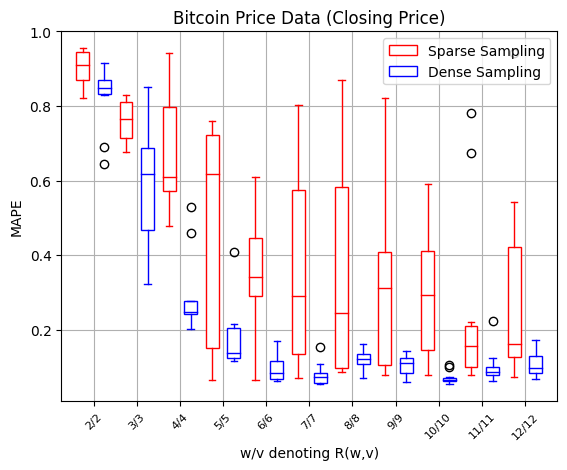

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load performance data
with open("perf_single_bitcoin1_winsor.txt", "rb") as f:
    perf1 = pickle.load(f)
with open("perf_single_bitcoin2_winsor.txt", "rb") as f:
    perf2 = pickle.load(f)

# Reshape performance data for plotting
A = np.array(perf1).reshape(-1, 10).transpose()
B = np.array(perf2).reshape(-1, 10).transpose()

# Print the results for MAPE
print("Performance 1 (MAPE):", perf1)
print("Performance 2 (MAPE):", perf2)

# Plotting function
def draw_plot(data, offset, edge_color, fill_color):
    pos = np.arange(data.shape[1]) + offset
    bp = ax.boxplot(data, positions=pos, widths=0.3, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
    return bp

fig, ax = plt.subplots()
bp1 = draw_plot(A, -0.25, "red", "white")
bp2 = draw_plot(B, +0.25, "blue", "white")
plt.title('Bitcoin Price Data (Closing Price)')
plt.xticks(np.arange(11), ['2/2', '3/3', '4/4', '5/5', '6/6', '7/7', '8/8', '9/9', '10/10', '11/11', '12/12'], rotation=45, fontsize=8)
plt.xlabel('w/v denoting R(w,v)')
plt.ylabel('MAPE')
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Sparse Sampling', 'Dense Sampling'], loc='best')
plt.grid()
plt.show()
plt.close()
